# Artificial neural network

In [1]:
#imports
from visualization.neural_network_plots import plot_loss, plot_accuracy, plot_multiple_loss_curves, plot_multiple_accuracy_curves
from preprocessing.preprocessing_one_hot_encoding import get_preprocessed_brfss_dataset_one_hot_encoded_train_test_split, get_preprocessed_brfss_dataset_one_hot_encoded_all_columns_train_test_split, get_preprocessed_brfss_dataset_one_hot_encoded_all_columns_train_test_split_undersampled,get_preprocessed_brfss_dataset_one_hot_encoded_all_columns_train_test_split_oversampled ,get_preprocessed_brfss_dataset_one_hot_encoded_train_test_split_undersampled

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data_utils

import numpy as np

In [3]:
import warnings
warnings.filterwarnings('ignore')

Create device for pytorch

In [4]:
use_mps = True
use_cuda = False

device = torch.device("cpu")

if torch.has_mps and use_mps:
    device = torch.device("mps")
    print("Torch mps activated")

if torch.has_cuda and use_cuda:
    device = torch.device("cuda")
    print("Torch cuda activated")

Torch mps activated


In [5]:
class CustomBrfssDataset(data_utils.Dataset):
    def __init__(self, dataset, dataset_target):
        self.dataset = torch.tensor(np.array(dataset)).float()
        self.target = torch.tensor(np.array(dataset_target)).float()

    def __len__(self):
            return len(self.dataset)

    def __getitem__(self, idx):
            return self.dataset[idx], self.target[idx]

Define artifical network

In [6]:
class Net(nn.Module):
    def __init__(self, input_size: int, output_size:int):
        super().__init__()
        self.fc1 = nn.Linear(input_size, 100)
        self.bn1 = nn.BatchNorm1d(100)
        self.do1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(100, 5)
        self.bn2 = nn.BatchNorm1d(5)
        self.do2 = nn.Dropout(0.5)
        self.fc3 = nn.Linear(5, output_size)

    def forward(self, inputs):
        x = self.fc1(inputs)
        x = self.bn1(x)
        x = F.relu(x, inplace=False)
        x = self.do1(x)
        x = self.fc2(x)
        x = self.bn2(x)
        x = F.relu(x, inplace=False)
        x = self.do2(x)
        x = self.fc3(x)
        x = F.softmax(x)
        return x

Define accuracy and loss function for network analysis and plots

In [7]:
def get_accuracy(model: Net, data_loader):
    correct = 0
    total = 0
    model.eval()
    with torch.no_grad():
        for i, data in enumerate(data_loader, 0):
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            _, labels = torch.max(labels.data, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return correct/total

def get_loss(model: Net, criterion, data_loader):
    running_loss = 0.0

    model.train()
    for i, data in enumerate(data_loader, 0):

        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        running_loss += loss.item()
        pass

    return running_loss/len(data_loader)

Training loop

In [8]:
def train_network(model: Net, criterion, optimizer, data_train_loader, data_validation_loader, n_epochs=5):
    loss_values = []
    accuracy_values = []
    loss_values_validation = []
    accuracy_values_validation = []

    for epoch in range(n_epochs):

        running_loss = 0.0

        model.train()
        for i, data in enumerate(data_train_loader, 0):

            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            if i % 100 == 99:  # print every 100 batches
                print(f'[{epoch + 1}, {(i + 1) * batch_size}] loss: {running_loss / i:.3f}')

            pass

        loss_values.append(running_loss/len(data_train_loader))
        validation_loss = get_loss(model, criterion, data_validation_loader)
        train_accuracy = 100 * get_accuracy(model, data_train_loader)
        validation_accuracy = 100 * get_accuracy(model, data_validation_loader)
        accuracy_values.append(train_accuracy)
        accuracy_values_validation.append(validation_accuracy)
        loss_values_validation.append(validation_loss)

        print(f"Epoch {epoch} loss: {str(running_loss/len(data_train_loader))}")
        print(f"Epoch {epoch} validation loss: {validation_loss}")
        print(f'Train accuracy epoch {epoch}: {train_accuracy} %')
        print(f'Validation accuracy epoch {epoch}: {validation_accuracy} %')

    print('Finished Training')
    return loss_values, loss_values_validation, accuracy_values, accuracy_values_validation

### Train model without under or oversampling

In [ ]:
data_train, data_validation, target_train, target_validation = get_preprocessed_brfss_dataset_one_hot_encoded_train_test_split(target_one_hot_encoded=True, include_test_data=False)

batch_size = 128
output_size = target_train.shape[1]
input_size = data_train.shape[1]
print(f"Input size: {input_size}")
print(f"Output size: {output_size}")

train_dataset = CustomBrfssDataset(data_train, target_train)
validation_dataset = CustomBrfssDataset(data_validation, target_validation)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size=batch_size, shuffle=True)

net = Net()
net.to(device)

criterion_cross_entropy = nn.CrossEntropyLoss()
optimizer_adam = optim.Adam(net.parameters(),lr=0.002)
loss_values, loss_values_validation, accuracy_values, accuracy_values_validation = train_network(model=net, criterion=criterion_cross_entropy, optimizer=optimizer_adam, data_train_loader=train_loader, data_validation_loader=validation_loader, n_epochs=10)

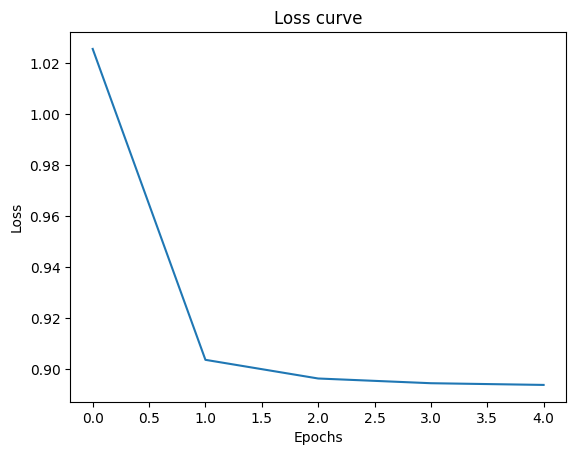

In [16]:
plot_loss(loss_values)

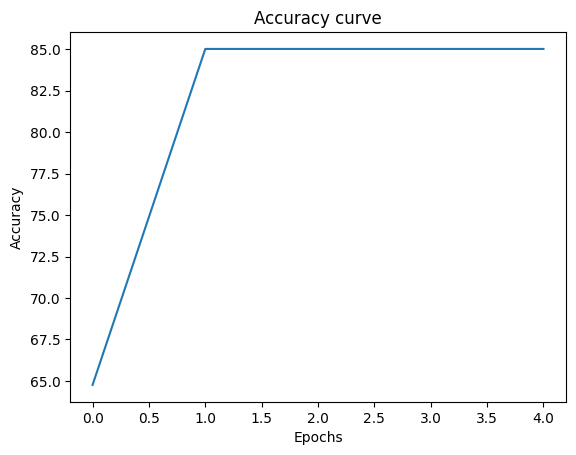

In [17]:
plot_accuracy(accuracy_values)

### Train model with undersampling

In [16]:
data_train, data_validation, target_train, target_validation = get_preprocessed_brfss_dataset_one_hot_encoded_all_columns_train_test_split(target_one_hot_encoded=True, include_test_data=False)

batch_size = 128
output_size = target_train.shape[1]
input_size = data_train.shape[1]
print(f"Input size: {input_size}")
print(f"Output size: {output_size}")

train_dataset = CustomBrfssDataset(data_train, target_train)
validation_dataset = CustomBrfssDataset(data_validation, target_validation)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size=batch_size, shuffle=True)

net = Net(input_size, output_size)
net.to(device)

criterion_cross_entropy = nn.CrossEntropyLoss()
optimizer_adam = optim.Adam(net.parameters(),lr=0.002)

loss_values, loss_values_validation, accuracy_values, accuracy_values_validation = train_network(model=net, criterion=criterion_cross_entropy, optimizer=optimizer_adam, data_train_loader=train_loader, data_validation_loader=validation_loader, n_epochs=10)

Input size: 92
Output size: 4
[1, 12800] loss: 1.182
[1, 25600] loss: 1.056
[1, 38400] loss: 1.001
[1, 51200] loss: 0.973
[1, 64000] loss: 0.956
[1, 76800] loss: 0.945
[1, 89600] loss: 0.937
[1, 102400] loss: 0.931
[1, 115200] loss: 0.926
[1, 128000] loss: 0.922
[1, 140800] loss: 0.919
[1, 153600] loss: 0.916
[1, 166400] loss: 0.914
[1, 179200] loss: 0.912
Epoch 0 loss: 0.9106916255650428
Epoch 0 validation loss: 0.8868982729158903
Train accuracy epoch 0: 85.01758753179286 %
Validation accuracy epoch 0: 85.01883198406858 %
[2, 12800] loss: 0.894
[2, 25600] loss: 0.889
[2, 38400] loss: 0.887
[2, 51200] loss: 0.887
[2, 64000] loss: 0.887
[2, 76800] loss: 0.887
[2, 89600] loss: 0.888
[2, 102400] loss: 0.887
[2, 115200] loss: 0.887
[2, 128000] loss: 0.887
[2, 140800] loss: 0.887
[2, 153600] loss: 0.887
[2, 166400] loss: 0.887
[2, 179200] loss: 0.887
Epoch 1 loss: 0.8861655051358188
Epoch 1 validation loss: 0.8863563978440874
Train accuracy epoch 1: 85.01758753179286 %
Validation accuracy e

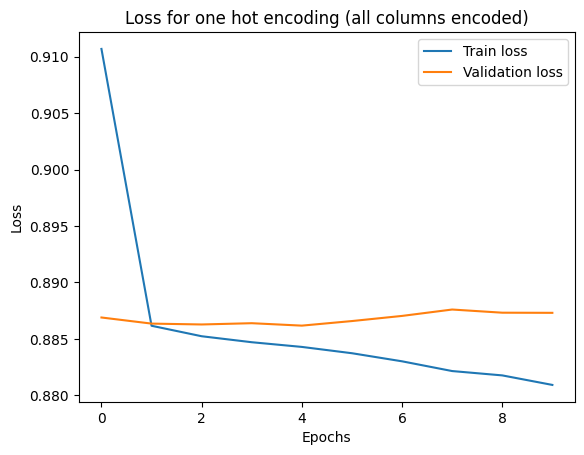

In [17]:
plot_multiple_loss_curves(loss_curves=[loss_values, loss_values_validation], labels=["Train loss","Validation loss"], title="Loss for one hot encoding")

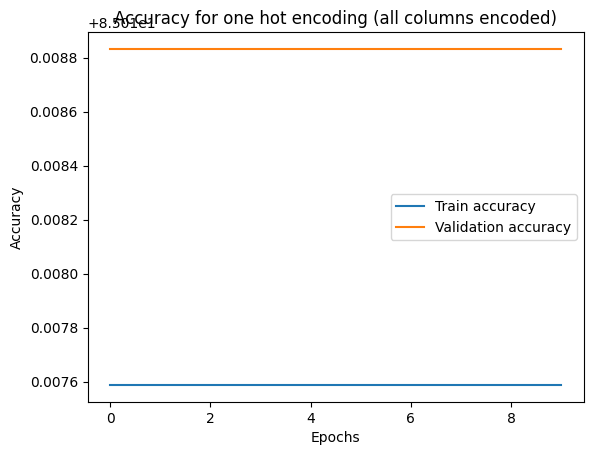

In [19]:
plot_multiple_accuracy_curves([accuracy_values, accuracy_values_validation], labels=["Train accuracy", "Validation accuracy"], title="Accuracy for one hot encoding")

In [12]:
data_train, data_validation, target_train, target_validation = get_preprocessed_brfss_dataset_one_hot_encoded_all_columns_train_test_split_undersampled(target_one_hot_encoded=True, include_test_data=False)

batch_size = 128
output_size = target_train.shape[1]
input_size = data_train.shape[1]
print(f"Input size: {input_size}")
print(f"Output size: {output_size}")

train_dataset = CustomBrfssDataset(data_train, target_train)
validation_dataset = CustomBrfssDataset(data_validation, target_validation)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size=batch_size, shuffle=True)

net = Net(input_size, output_size)
net.to(device)

criterion_cross_entropy = nn.CrossEntropyLoss()
optimizer_adam = optim.Adam(net.parameters(),lr=0.002)

loss_values, loss_values_validation, accuracy_values, accuracy_values_validation = train_network(model=net, criterion=criterion_cross_entropy, optimizer=optimizer_adam, data_train_loader=train_loader, data_validation_loader=validation_loader, n_epochs=50)

Input size: 92
Output size: 4
Epoch 0 loss: 1.340812828540802
Epoch 0 validation loss: 1.3855246298861306
Train accuracy epoch 0: 40.04452926208651 %
Validation accuracy epoch 0: 39.13805792458548 %
Epoch 1 loss: 1.275539631843567
Epoch 1 validation loss: 1.4264320679978981
Train accuracy epoch 1: 44.87913486005089 %
Validation accuracy epoch 1: 32.48841941209576 %
Epoch 2 loss: 1.243192162513733
Epoch 2 validation loss: 1.4367685889273138
Train accuracy epoch 2: 47.041984732824424 %
Validation accuracy epoch 2: 43.97160050218624 %
Epoch 3 loss: 1.2199971985816955
Epoch 3 validation loss: 1.4321831078410479
Train accuracy epoch 3: 46.58078880407125 %
Validation accuracy epoch 3: 55.11710463656435 %
Epoch 4 loss: 1.2023859691619874
Epoch 4 validation loss: 1.4416675703017006
Train accuracy epoch 4: 45.578880407124686 %
Validation accuracy epoch 4: 61.99619031126888 %
Epoch 5 loss: 1.181272485256195
Epoch 5 validation loss: 1.4379289226188554
Train accuracy epoch 5: 44.958651399491096 %


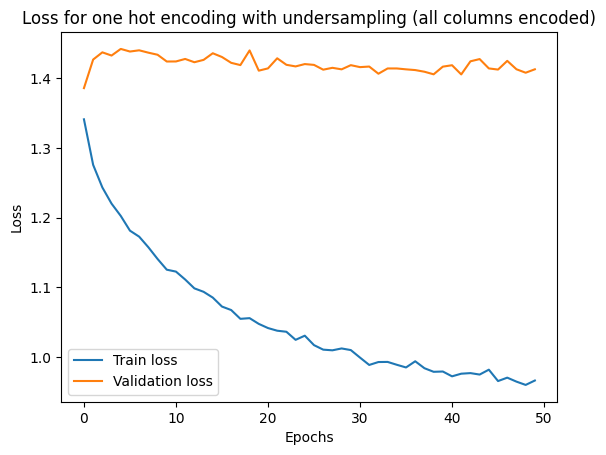

In [13]:
plot_multiple_loss_curves(loss_curves=[loss_values, loss_values_validation], labels=["Train loss","Validation loss"], title="Loss for one hot encoding with undersampling (all columns encoded)")

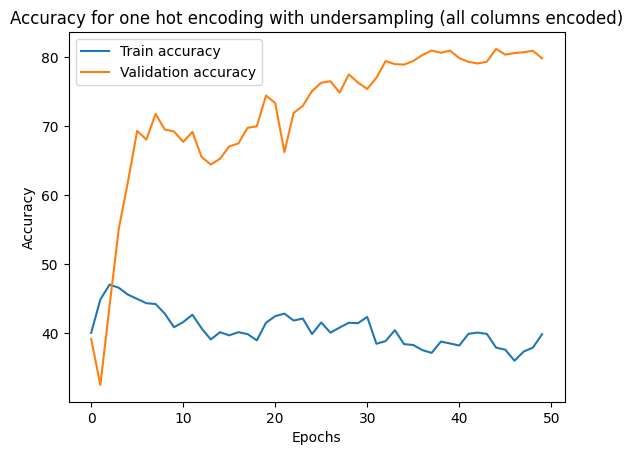

In [14]:
plot_multiple_accuracy_curves([accuracy_values, accuracy_values_validation], labels=["Train accuracy", "Validation accuracy"], title="Accuracy for one hot encoding with undersampling (all columns encoded)")

In [ ]:
data_train, data_validation, target_train, target_validation = get_preprocessed_brfss_dataset_one_hot_encoded_all_columns_train_test_split_oversampled(target_one_hot_encoded=True, include_test_data=False)

batch_size = 128
output_size = target_train.shape[1]
input_size = data_train.shape[1]
print(f"Input size: {input_size}")
print(f"Output size: {output_size}")

train_dataset = CustomBrfssDataset(data_train, target_train)
validation_dataset = CustomBrfssDataset(data_validation, target_validation)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size=batch_size, shuffle=True)

net = Net(input_size, output_size)
net.to(device)

criterion_cross_entropy = nn.CrossEntropyLoss()
optimizer_adam = optim.Adam(net.parameters(),lr=0.002)

loss_values, loss_values_validation, accuracy_values, accuracy_values_validation = train_network(model=net, criterion=criterion_cross_entropy, optimizer=optimizer_adam, data_train_loader=train_loader, data_validation_loader=validation_loader, n_epochs=10)

Input size: 92
Output size: 4
[1, 12800] loss: 1.312
[1, 25600] loss: 1.276
[1, 38400] loss: 1.258
[1, 51200] loss: 1.244
[1, 64000] loss: 1.233
[1, 76800] loss: 1.223
[1, 89600] loss: 1.216
[1, 102400] loss: 1.210
[1, 115200] loss: 1.204
[1, 128000] loss: 1.198
[1, 140800] loss: 1.193
[1, 153600] loss: 1.189
[1, 166400] loss: 1.186
[1, 179200] loss: 1.183
[1, 192000] loss: 1.180
[1, 204800] loss: 1.177
[1, 217600] loss: 1.174
[1, 230400] loss: 1.172
[1, 243200] loss: 1.169
[1, 256000] loss: 1.167
[1, 268800] loss: 1.165
[1, 281600] loss: 1.164
[1, 294400] loss: 1.161
[1, 307200] loss: 1.159
[1, 320000] loss: 1.158
[1, 332800] loss: 1.156
[1, 345600] loss: 1.155
[1, 358400] loss: 1.153
[1, 371200] loss: 1.152
[1, 384000] loss: 1.150
[1, 396800] loss: 1.149
[1, 409600] loss: 1.147
[1, 422400] loss: 1.146
[1, 435200] loss: 1.145
[1, 448000] loss: 1.143
[1, 460800] loss: 1.142
[1, 473600] loss: 1.141
[1, 486400] loss: 1.140
[1, 499200] loss: 1.139
[1, 512000] loss: 1.138
[1, 524800] loss:

In [ ]:
plot_multiple_loss_curves(loss_curves=[loss_values, loss_values_validation], labels=["Train loss","Validation loss"], title="Loss for one hot encoding with oversampling (all columns encoded)")

In [ ]:
plot_multiple_accuracy_curves([accuracy_values, accuracy_values_validation], labels=["Train accuracy", "Validation accuracy"], title="Accuracy for one hot encoding with oversampling (all columns encoded)")